In [1]:
!python -V

Python 3.10.9


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Q1. Read the data for January. How many columns are there?
    Answer: 19

In [6]:
df = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')
len(df.columns)
df.shape[1]

19

In [7]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

#### Q2. What's the standard deviation of the trips duration in January?
    Answer:46.45

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
std_duration = df['duration'].std()
print(std_duration)

46.44530513776499


In [9]:
# Calculate the percentiles
perc_95 = df['duration'].quantile(0.95)
perc_85 = df['duration'].quantile(0.85)
perc_75 = df['duration'].quantile(0.75)

# Count the number of durations less than or equal to these percentiles
count_95 = df[df['duration'] <= perc_95].shape[0]
count_85 = df[df['duration'] <= perc_85].shape[0]
count_75 = df[df['duration'] <= perc_75].shape[0]

# Print out the results
print("95% of the durations are less than or equal to: ", perc_95, " Number of such durations: ", count_95)
print("85% of the durations are less than or equal to: ", perc_85, " Number of such durations: ", count_85)
print("75% of the durations are less than or equal to: ", perc_75, " Number of such durations: ", count_75)


95% of the durations are less than or equal to:  31.933333333333334  Number of such durations:  2340853
85% of the durations are less than or equal to:  20.716666666666665  Number of such durations:  2094757
75% of the durations are less than or equal to:  16.166666666666668  Number of such durations:  1848970


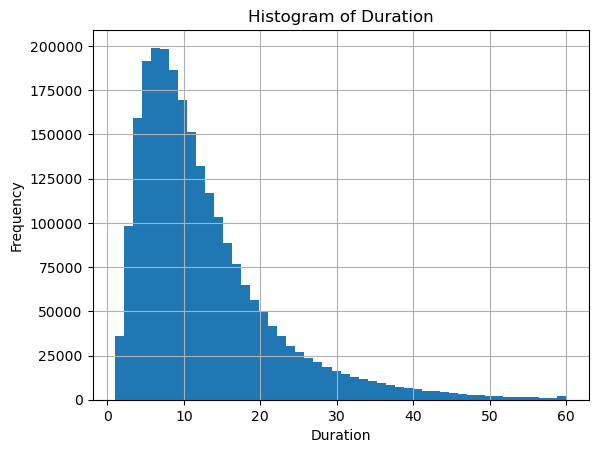

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

df['duration'].hist(bins=50)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Duration')
plt.show()

#### Q3. What fraction of the records left after you dropped the outliers?
    Answer: 98.27%

In [54]:
df_original = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')
rows_original = df_original.shape[0]
rows_dropped = df.shape[0]
fraction = rows_dropped/rows_original
print(fraction)

0.9827547930522406


#### Q4. What's the dimensionality of this matrix (number of columns)?
    Answer: 515

In [55]:
# Specify the categorical columns
cate_2f = ['PULocationID', 'DOLocationID']

# Convert the selected DataFrame columns to string and then to a list of dictionaries
df_2f = df[cate_2f].astype(str).to_dict(orient='records')

# Initialize the DictVectorizer
dv = DictVectorizer()

# Fit and transform to get the feature matrix
df_encoded = dv.fit_transform(df_2f)

# Print the number of columns in the matrix
print(df_encoded.shape[1])


515


In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

#### Q5. What's the RMSE on train?
    Answer: 7.00

In [16]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, squared=False)

print(rmse)

7.001496179360082


In [32]:
std_duration = df['duration'].std()

In [72]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [73]:
df_train = read_dataframe('data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('data/yellow_tripdata_2022-02.parquet')

In [74]:
df_train.shape[1], df_val.shape[1]

(20, 20)

In [75]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [78]:
df_train['PU_DO'].dtype, df_train['PULocationID'].dtype

(dtype('O'), dtype('O'))

In [79]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [80]:
X_train.shape[1], X_val.shape[1]

(20667, 20667)

In [81]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

#### Q6. What's the RMSE on validation?
    Answer: 5.53

In [84]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530638694571134

In [86]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [88]:
import os

file_path = 'models/lin_reg.bin'
absolute_path = os.path.abspath(file_path)

print(absolute_path)

/home/rex/mlops-zoomcamp/01-intro/models/lin_reg.bin


/tmp/ipykernel_1476/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1476/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


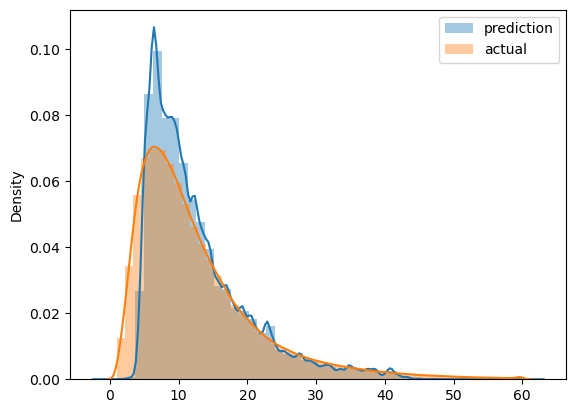

In [87]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()